# Geopotential

In this section, we will formulate the perturbation experienced by an Earth-orbiting spacecraft due to Earth's non-spherical mass distribution.

## Theoretical background

In an Earth-fixed frame, Earth's gravitational potential (i.e., the [geopotential](https://en.wikipedia.org/wiki/Geopotential)) can be written as:

$$
U\left( r, \phi, \lambda \right) = \frac{GM_\oplus}{r} \sum_{n=0}^{\infty} \sum_{m=0}^{n} \left( \frac{R_\oplus}{r} \right)^n P_{nm}(\sin\phi) \left( C_{nm} \cos(m\lambda) + S_{nm} \sin(m\lambda) \right),
$$

where $\left( r, \phi, \lambda \right)$ are spherical coordinates (radial distance, latitude and longitude), $GM_\oplus$ is Earth's [gravitational parameter](https://en.wikipedia.org/wiki/Standard_gravitational_parameter), $R_\oplus$ is a reference radius (usually chosen as Earth's equatorial radius), $P_{nm}$ are [associated Legendre polynomials](https://en.wikipedia.org/wiki/Associated_Legendre_polynomials) and $C_{nm}$ and $S_{nm}$ are numerical coefficients. The geopotential coefficients $C_{nm}$ and $S_{nm}$ depend on Earth's internal mass distribution, $M_\oplus$, $R_\oplus$ and the chosen reference frame. For astrodynamical applications, the geopotential is usually reformulated in terms of Cartesian coordinates $\left( x, y, z \right)$, and its gradient is then computed to yield the corresponding gravitational acceleration.

heyoka.py provides an implementation of the [EGM2008](https://en.wikipedia.org/wiki/Earth_Gravitational_Model#EGM2008) geopotential model, described in detail in a [separate tutorial](<./egm2008.ipynb>). Here we will be using the {py:func}`~heyoka.model.egm2008_acc()` function, which takes in input a Cartesian position vector in the Earth-fixed [ITRS](https://en.wikipedia.org/wiki/International_Terrestrial_Reference_System_and_Frame) frame and returns the Cartesian components (also in the ITRS) of the acceleration due to the geopotential.

While the inputs and outputs of {py:func}`~heyoka.model.egm2008_acc()` are referred to the non-inertial ITRS, orbit propagation is commonly formulated in the axes of an inertial frame of reference, such as the [ICRS](https://en.wikipedia.org/wiki/International_Celestial_Reference_System_and_its_realizations). Both the inputs and the outputs of {py:func}`~heyoka.model.egm2008_acc()` will thus have to be rotated.

## Formulating the perturbing acceleration

We begin by importing the main modules and setting up a few constants:

In [1]:
import heyoka as hy
import numpy as np
import pykep as pk

# Seconds in a day.
sday = 86400.0
# Days in a century.
dcy = 36525.0

# Earth's gravitational parameter and Earth radius
# in the EGM2008 model (SI units).
muE = hy.model.get_egm2008_mu()
RE = hy.model.get_egm2008_a()

# Maximum degree/order for the geopotential.
n = 16
m = 16

Note how we set as maximum degree/order for the geopotential coefficients $n=m=16$.

Next, we set up symbolic variables to represent the Cartesian state vector of the spacecraft in the [GCRS](https://en.wikipedia.org/wiki/Barycentric_and_geocentric_celestial_reference_systems) (this is a reference frame centred on the Earth and whose axes have the same orientation as the ICRS):

In [2]:
x, y, z, vx, vy, vz = hy.make_vars("x", "y", "z", "vx", "vy", "vz")

These are the state variables that we will be using to propagate the orbit of the spacecraft.

As explained earlier, we need to rotate the positions to the ITRS before feeding them to {py:func}`~heyoka.model.egm2008_acc()`. We can do this via the {py:func}`~heyoka.model.rot_icrs_itrs()` function:

In [3]:
x_itrs, y_itrs, z_itrs = hy.model.rot_icrs_itrs(
    [x, y, z], thresh=1e-3, time_expr=hy.time / (sday * dcy)
)

Recall that the {py:func}`~heyoka.model.rot_icrs_itrs()` function accepts as optional input a ``thresh`` argument used to tune the accuracy/performance ratio of the precession/nutation model. By using a threshold of $10^{-3}$, we are foregoing the full model in order to improve processing speed. We are also passing a custom ``time_expr`` argument to change the time coordinate from Julian centuries since J2000 (i.e., the original time coordinate used by the precession/nutation model) to seconds since J2000. Please see the [IAU2006 model tutorial](<./iau2006.ipynb>) for more info.

We can now proceed to compute the components of the acceleration vector in the ITRS:

In [4]:
acc_x_itrs, acc_y_itrs, acc_z_itrs = hy.model.egm2008_acc(
    [x_itrs, y_itrs, z_itrs], n, m
)

The last step is to rotate the components of the acceleration vector back to the GCRS:

In [5]:
acc_x_gcrs, acc_y_gcrs, acc_z_gcrs = hy.model.rot_itrs_icrs(
    [acc_x_itrs, acc_y_itrs, acc_z_itrs], thresh=1e-3, time_expr=hy.time / (sday * dcy)
)

## Checking the implementation

As an initial check, we will be computing (via a [compiled function](<./compiled_functions.ipynb>)) how the geopotential acceleration in a point **fixed in the GCRS** varies over time.

Let us introduce the compiled function:

In [6]:
cf_acc_gcrs = hy.cfunc([acc_x_gcrs, acc_y_gcrs, acc_z_gcrs], vars=[x, y, z])

Next we define a timespan over approximately 10 [sidereal days](https://en.wikipedia.org/wiki/Sidereal_time):

In [7]:
tspan = np.linspace(0, 86164.0905 * 10, 1000)

And a GCRS position vector in LEO (SI units):

In [8]:
pos_leo = [(6370 + 410) * 1000.0, 0.0, 0.0]

We can now proceed to compute and plot the evolution in time of the acceleration:

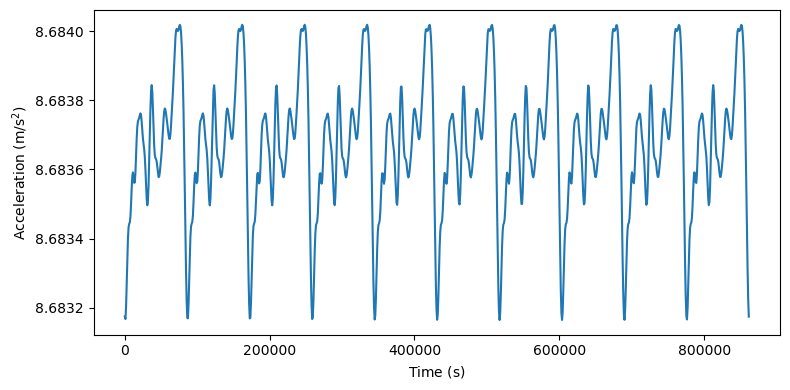

In [9]:
%matplotlib inline
from matplotlib.pylab import plt

fig = plt.figure(figsize=(8, 4))

# Compute the acceleration over the timespan.
acc_gcrs_hist = cf_acc_gcrs(
    np.repeat(pos_leo, len(tspan), axis=0).reshape((3, -1)), time=tspan
)

# Plot the magnitude of the acceleration.
plt.plot(tspan, np.linalg.norm(acc_gcrs_hist, axis=0))

plt.xlabel(r"Time ($\mathrm{s}$)")
plt.ylabel(r"Acceleration ($\mathrm{m}/\mathrm{s}^2$)")

plt.tight_layout()

We can see how the result is qualitatively and quantitatively consistent with what we expect: we clearly see the diurnal periodicity of the acceleration due to Earth's rotation, and the average acceleration value is what we expect at $410\,\mathrm{km}$ of altitude.

As a second test, we can set up a numerical integration to check that the nodal precession of the spacecraft's orbit matches (roughly) the [precession due to the $J2$ geopotential coefficient](https://en.wikipedia.org/wiki/Nodal_precession).

We begin by setting up initial conditions for an inclined, low-eccentricity LEO orbit:

In [10]:
# Orbital elements.
kep_a = (6378 + 500) * 1e3
kep_e = 0.02
kep_i = 0.5236

# Convert to Cartesian.
r0, v0 = pk.par2ic([kep_a, kep_e, kep_i, 0.0, 0.0, 0.0], muE)

Next, we set up the dynamical equations and the numerical integrator:

In [11]:
# Dynamics.
dyn = [(x, vx), (y, vy), (z, vz), (vx, acc_x_gcrs), (vy, acc_y_gcrs), (vz, acc_z_gcrs)]

# Integrator.
ta = hy.taylor_adaptive(dyn, state=r0 + v0, compact_mode=True, tol=1e-15)

We can now perform a numerical integration over the timespan of a day:

In [12]:
tspan = np.linspace(0, sday, 1000)
res = ta.propagate_grid(tspan)

Recall that we are measuring time in seconds elapsed since the epoch of J2000.

We can now proceed to extract the time evolution of the [longitude of the ascending node](https://en.wikipedia.org/wiki/Longitude_of_the_ascending_node) $\Omega$:

In [13]:
Om_hist = np.unwrap([pk.ic2par(_[:3], _[3:6], muE)[3] for _ in res[-1]])

Let us plot the time evolution of $\Omega$, together with the expected precession rate:

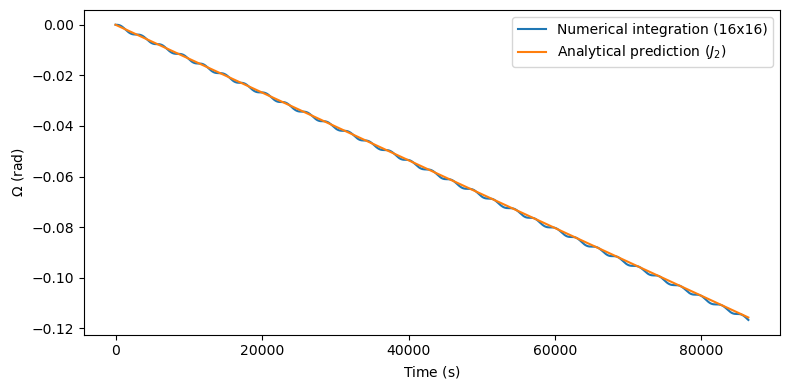

In [14]:
# Compute the expected precession rate (approximate value). See:
# https://en.wikipedia.org/wiki/Nodal_precession
J2 = 1.082626e-3
Om_p = (
    -3
    / 2.0
    * RE**2
    / (kep_a * (1 - kep_e**2)) ** 2
    * J2
    * np.cos(kep_i)
    * np.sqrt(muE / kep_a**3)
)

fig = plt.figure(figsize=(8, 4))

plt.plot(tspan, Om_hist, label=f"Numerical integration ({n}x{m})")
plt.plot(tspan, tspan * Om_p, label=r"Analytical prediction ($J_2$)")

plt.xlabel(r"Time ($\mathrm{s}$)")
plt.ylabel(r"$\Omega$ ($\mathrm{rad}$)")

plt.legend()

plt.tight_layout()

We can see a good agreement between the analytical prediction and the numerical integration (keeping in mind that in the numerical integration we are considering several more geopotential terms in addition to $J_2$).

## Sensitivity to precession/nutation fidelity

In the previous sections, we ran a few numerical experiments in which we used a truncated version of Earth's precession/nutation model. In this section, we want to quantify the effects of such truncation on the accuracy of the numerical propagation of a LEO trajectory.

We start off by introducing a small helper that generates the dynamics induced by the geopotential for a specific input value of the precession/nutation truncation threshold:

In [15]:
# Helper to generate the dynamics of an Earth-orbiting spacecraft
# due to the Earth's geopotential.
def get_geopot_dyn(thresh: float):
    x_itrs, y_itrs, z_itrs = hy.model.rot_icrs_itrs(
        [x, y, z], thresh=thresh, time_expr=hy.time / (sday * dcy)
    )

    acc_x_itrs, acc_y_itrs, acc_z_itrs = hy.model.egm2008_acc(
        [x_itrs, y_itrs, z_itrs], n, m
    )

    acc_x_gcrs, acc_y_gcrs, acc_z_gcrs = hy.model.rot_itrs_icrs(
        [acc_x_itrs, acc_y_itrs, acc_z_itrs],
        thresh=thresh,
        time_expr=hy.time / (sday * dcy),
    )

    return [
        (x, vx),
        (y, vy),
        (z, vz),
        (vx, acc_x_gcrs),
        (vy, acc_y_gcrs),
        (vz, acc_z_gcrs),
    ]

We then run our "ground truth" numerical integration with a threshold of zero (that is, using the full precession/nutation model):

In [16]:
ta_gt = hy.taylor_adaptive(
    get_geopot_dyn(thresh=0.0), state=r0 + v0, compact_mode=True, tol=1e-15
)
res_gt = ta_gt.propagate_grid(tspan)[-1]

Next, we run several numerical integrations at different nonzero threshold levels:

In [17]:
res_list = []
thresh_list = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0]
for thresh in thresh_list:
    cur_ta = hy.taylor_adaptive(
        get_geopot_dyn(thresh=thresh), state=r0 + v0, compact_mode=True, tol=1e-15
    )
    res_list.append(cur_ta.propagate_grid(tspan)[-1])

We can now proceed to visualise the positional error of the numerical integrations with the truncated model with respect to the numerical integration with the full precession/nutation model:

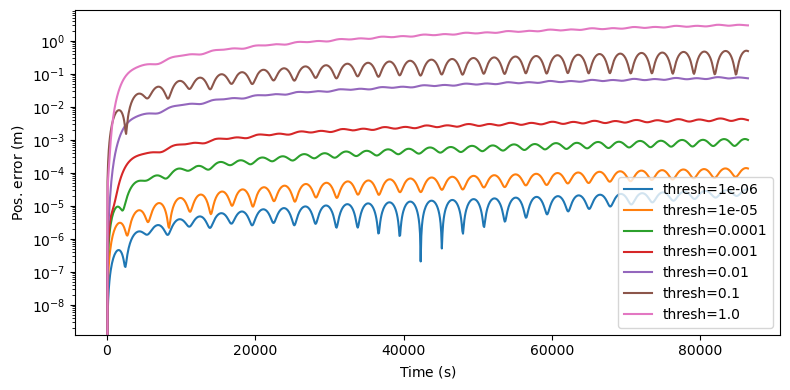

In [18]:
fig = plt.figure(figsize=(8, 4))

for cur_res, cur_thresh in zip(res_list, thresh_list):
    plt.semilogy(
        tspan,
        np.linalg.norm(cur_res[:, :3] - res_gt[:, :3], axis=1),
        label=f"thresh={cur_thresh}",
    )

plt.xlabel(r"Time ($\mathrm{s}$)")
plt.ylabel(r"Pos. error ($\mathrm{m}$)")
plt.legend()

plt.tight_layout()

We can see how the positional error progressively increases with higher truncation thresholds, as expected. A truncation threshold of $10^{-3}$ is able to deliver a positional error in the order of millimetres over a propagation time of one day.